In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm
#matplotlib.rcParams.update({'font.size': 15})
mpl.rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'figure.figsize': (3,2)})
import pandas as pd
import seaborn as sns
from copy import deepcopy

import sys
import os
import subprocess
import glob
from collections import defaultdict
import scipy as sp
from scipy import special
from itertools import product

from scipy.io import savemat

In [2]:
# temps = [0.1, 0.04, 0.01, 0.004, 0.001]
# times = [1, 10, 100]
# params = list(product(temps, times))
# temp, time = params[0]


In [3]:
# data_files

In [29]:
def normal_weight_many(Ibs, dV, beta):
    """
    Calculate generic weights
    """
    weights = np.exp(-(Ibs[:,:,0]*dV**2 + Ibs[:,:,1]*dV)*beta)
    return weights


def dynamics_msd_many(pos, init_x):
    """
    Calculate MSD(t) for a large slice of trajectories
    """
    msd = (1/pos.shape[2])*np.sum(np.square(pos - init_x), axis=(2,3))
    return msd


def dynamics_q_many(pos, init_x, a):
    """
    Calculate Q(t) for a large slice of trajectories
    """
    part_msd = np.sqrt(np.sum(np.square(pos - init_x), axis=3))
    q = np.mean(np.heaviside(a - part_msd, 0.5), axis=2)
    return q


def dynamics_q_many_as(pos, init_x, As):
    """
    Calculate Q(t) for a large slice of trajectories
    """
    part_msd = np.sqrt(np.sum(np.square(pos - init_x), axis=3))
    shape = part_msd.shape
    qs = np.zeros((len(As), shape[0], shape[1]))
    for i, a in enumerate(As):
        qs[i] = np.mean(np.heaviside(a - part_msd, 0.5), axis=2)
    return qs

def process_variant_batch(files, beta, dVs, sys_params=(100,10,2), max_slice=10_000):
    """
    Calculate all quantities for a group of files
    """
    
    time_steps = sys_params[0]
    num_parts = sys_params[1]
    dim = sys_params[2]
    
    qs = 10
    
    N = 0
    norm = np.zeros((len(dVs), time_steps))
    norm_square = np.zeros((len(dVs), time_steps))
    pos_bias = np.zeros((len(dVs), time_steps, num_parts, dim))
    MSD_bias = np.zeros((len(dVs), time_steps))
    Q_bias = np.zeros((qs, len(dVs), time_steps))
    As = np.linspace(0.1, 1.0, qs)
    
    for f in files:
        with h5py.File(f, "r") as f:
            Ibs_hdl = f["data"]["Ib"]
            whole_data_len = len(Ibs_hdl)
            chunks = int(np.ceil(whole_data_len/max_slice))
            pos_hdl = f["data"]["pos"]
            time = f["data"]["time"][:]
            
            pos_shape = pos_hdl.shape
            assert(len(time) == time_steps)
            assert(pos_shape[2] == num_parts)
            assert(pos_shape[3] >= dim)
            
            init_x = f["meta"]["init_x"][:,:dim]

            for i in range(chunks):
                print(chunks, i)
                Ibs = Ibs_hdl[i*max_slice:(i+1)*max_slice]
                pos = pos_hdl[i*max_slice:(i+1)*max_slice,:,:,:dim]
                msd = dynamics_msd_many(pos, init_x)
                N += len(Ibs)
                qs = dynamics_q_many_as(pos, init_x, As)
                for j, dV in enumerate(dVs):
                    weights = normal_weight_many(Ibs, dV, beta)
                    norm[j] += np.sum(weights, axis=0)
                    norm_square[j] += np.sum(weights*weights, axis=0)
                    MSD_bias[j] += np.sum(weights*msd, axis=0)
                    for k in range(len(Q_bias)):
                        Q_bias[k, j] += np.sum(weights*qs[k], axis=0)
                    for k in range(pos_bias.shape[0]):
                        for l in range(pos_bias.shape[1]):
                            tmp = weights[k, l]*pos[:,l]
                            pos_bias[k, l] += np.sum(tmp, axis=0)
                    

    for i in range(len(Q_bias)):
        Q_bias[i] /= norm
    MSD_bias /= norm
    pos_shape = pos_bias.shape
    for i in range(pos_shape[0]):
        for j in range(pos_shape[1]):
            pos_bias[i, j] /= norm[i, j]
    Ib_mean = norm/N
    Ib_var = norm_square/N - Ib_mean*Ib_mean
    
    out_dict = {"time": time, "dVs": dVs, "Ib_mean": Ib_mean, "Ib_var": Ib_var, 
                "MSD_bias": MSD_bias, "Q_bias": Q_bias, "As": As, "pos_bias": pos_bias,
                "beta": beta, "N": N, "num_parts": num_parts, "dim": dim, "init_pos": init_x,
                "visc": 5.0, "L": 3.5}
    
    return out_dict

In [30]:
dVs = np.linspace(-10.0, 0.0, 11)
dVs

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.])

In [ ]:
temps = [0.1, 0.04, 0.01, 0.004, 0.001]
times = [1, 10, 100]
params = list(product(temps, times))
for temp, time in params:
    beta = 1/temp

    data_files = glob.glob(f"/home/igraham/data/md-lv/genvariant_*_t-{temp}_time-{time}_*")
    print(beta, data_files)
    my_dict = process_variant_batch(data_files, beta, dVs)

    np.savez(f"/home/igraham/data/md-lv/process_fixed_t-{temp}_time-{time}.npz", **my_dict)

10.0 ['/home/igraham/data/md-lv/genvariant_n-10_l-3.5_t-0.1_time-1_dt-1e-3_visc-5_seed-1_phi-0.9489_rA-0.5000_rB-0.7000_vs-1.h5']
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
100 10
100 11
100 12
100 13
100 14
100 15
100 16
100 17
100 18
100 19
100 20
100 21
100 22
100 23
100 24
100 25
100 26
100 27
100 28
100 29
100 30
100 31
100 32
100 33
100 34
100 35
100 36
100 37
100 38
100 39
100 40
100 41
100 42
100 43
100 44
100 45
100 46
100 47
100 48
100 49
100 50
100 51
100 52
100 53
100 54
100 55
100 56
100 57
100 58
100 59
100 60
100 61
100 62
100 63
100 64
100 65
100 66
100 67
100 68
100 69
100 70
100 71
100 72
100 73
100 74
100 75
100 76
100 77
100 78
100 79
100 80
100 81
100 82
100 83
100 84
100 85
100 86
100 87
100 88
100 89
100 90
100 91
100 92
100 93
100 94
100 95
100 96
100 97
100 98
100 99
10.0 ['/home/igraham/data/md-lv/genvariant_n-10_l-3.5_t-0.1_time-10_dt-1e-3_visc-5_seed-2_phi-0.9489_rA-0.5000_rB-0.7000_vs-1.h5']
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
1

<ipython-input-29-f0415f4eaf20>:92: RuntimeWarning: invalid value encountered in true_divide
  Q_bias[i] /= norm
<ipython-input-29-f0415f4eaf20>:93: RuntimeWarning: invalid value encountered in true_divide
  MSD_bias /= norm
<ipython-input-29-f0415f4eaf20>:97: RuntimeWarning: overflow encountered in true_divide
  pos_bias[i, j] /= norm[i, j]
<ipython-input-29-f0415f4eaf20>:97: RuntimeWarning: divide by zero encountered in true_divide
  pos_bias[i, j] /= norm[i, j]


25.0 ['/home/igraham/data/md-lv/genvariant_n-10_l-3.5_t-0.04_time-1_dt-1e-3_visc-5_seed-3_phi-0.9489_rA-0.5000_rB-0.7000_vs-1.h5']
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
100 10
100 11
100 12
100 13
100 14
100 15
100 16
100 17
100 18
100 19
100 20
100 21
100 22
100 23
100 24
100 25
100 26
100 27
100 28
100 29
100 30
100 31
100 32
100 33
100 34
100 35
100 36
100 37
100 38
100 39
100 40
100 41
100 42
100 43
100 44
100 45
100 46
100 47
100 48
100 49
100 50
100 51
100 52
100 53
100 54
100 55
100 56
100 57
100 58
100 59
100 60
100 61
100 62
100 63
100 64
100 65
100 66
100 67
100 68
100 69
100 70
100 71
100 72
100 73
100 74
100 75
100 76
100 77
100 78
100 79
100 80
100 81
100 82
100 83
100 84
100 85
100 86
100 87
100 88
100 89
100 90
100 91
100 92
100 93
100 94
100 95
100 96
100 97
100 98
100 99
25.0 ['/home/igraham/data/md-lv/genvariant_n-10_l-3.5_t-0.04_time-10_dt-1e-3_visc-5_seed-4_phi-0.9489_rA-0.5000_rB-0.7000_vs-1.h5']
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7

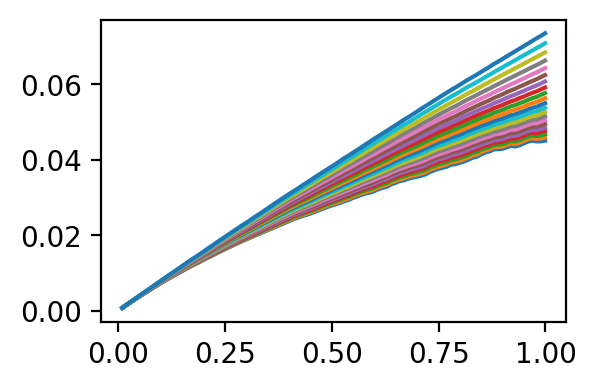

In [169]:
for i in range(len(MSD_bias)):
    plt.plot(time, MSD_bias[i])

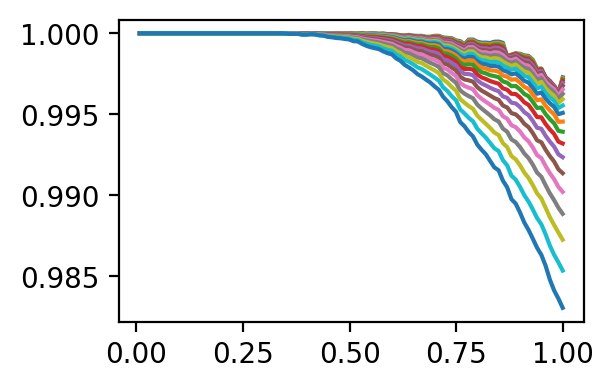

In [170]:
for i in range(len(Q_bias)):
    plt.plot(time, Q_bias[i])

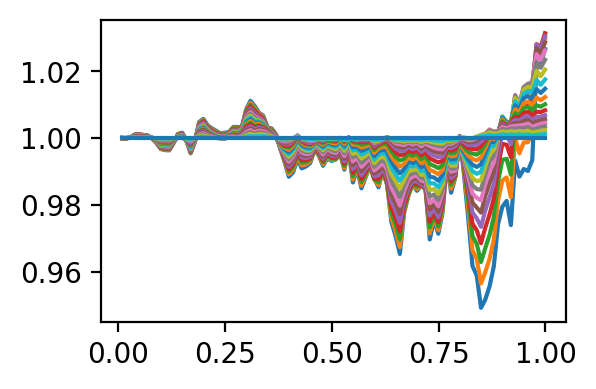

In [171]:
for i in range(len(Ib_mean)):
    plt.plot(time, Ib_mean[i])

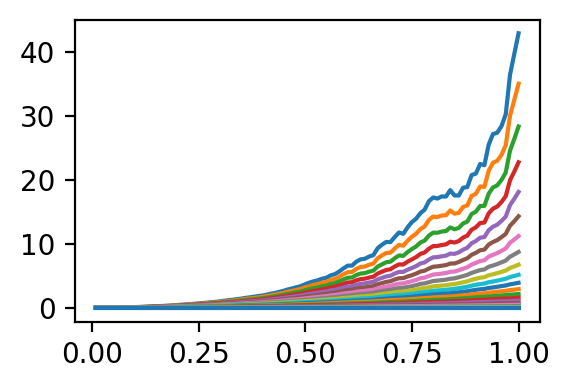

In [172]:
for i in range(len(Ib_var)):
    plt.plot(time, Ib_var[i])

In [ ]:
temp, time